# Group Project: Hazel Choe - Minh Trinh (Business, Investment & Revenue Analysis)

# Name: Hazel Choe

# Data scraping

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import time
import re

driver = webdriver.Chrome()

all_data = []

# Companies URL
ticker_urls = {
    "BLK":   "https://companiesmarketcap.com/blackrock/revenue/",
    "JPM":   "https://companiesmarketcap.com/jp-morgan-chase/revenue/", 
    "KO":    "https://companiesmarketcap.com/coca-cola/revenue/",
    "NSRGY": "https://companiesmarketcap.com/nestle/revenue/",
    "WHG": "https://companiesmarketcap.com/westwood-holdings-group/revenue/",
    "FHI": "https://companiesmarketcap.com/federated-hermes/revenue/",
    "AMG": "https://companiesmarketcap.com/affiliated-managers-group/revenue/",
    "DHIL": "https://companiesmarketcap.com/diamond-hill/revenue/",
    "AB": "https://companiesmarketcap.com/alliancebernstein/revenue/",
    "FDP": "https://companiesmarketcap.com/fresh-del-monte-produce/revenue/",
    "WDFC": "https://companiesmarketcap.com/wd-40-company/revenue/",
    "JJSF": "https://companiesmarketcap.com/jj-snacks-foods/revenue/"

}

REVENUE_TAB_XPATH = '//*[@id="cmkt"]/div[3]/ul/li[2]/a'
ROWS_XPATH        = '//*[@id="cmkt"]/div[3]/div[2]/div[3]/table/tbody/tr'

def try_click_revenue_tab():
    """If the rows aren't visible yet, try clicking the Revenue tab."""
    try:
        rows = driver.find_elements(By.XPATH, ROWS_XPATH)
        if rows:
            return
        tab = driver.find_element(By.XPATH, REVENUE_TAB_XPATH)
        tab.click()
        time.sleep(1.0)
    except Exception:
        pass

def extract_year_int(raw_year: str):
    m = re.search(r"(\d{4})", raw_year or "")
    return int(m.group(1)) if m else None

for ticker, url in ticker_urls.items():
    driver.get(url)
    time.sleep(1.2) 

    try_click_revenue_tab()
    time.sleep(0.8)

    rows = driver.find_elements(By.XPATH, ROWS_XPATH)

    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        if len(cols) < 3:
            continue

        raw_year = cols[0].text.strip()   
        raw_rev  = cols[1].text.strip()   
        raw_chg  = cols[2].text.strip()   

        if not raw_year or not raw_rev:
            continue

        year = extract_year_int(raw_year)
        all_data.append([ticker, raw_year, year, raw_rev, raw_chg])

    print(f"Finished {ticker}")

driver.quit()

df = pd.DataFrame(
    all_data,
    columns=["ticker", "raw_year", "year", "raw_revenue", "raw_change"]
)

print(df.head())
df.to_csv("/Users/hazel/Desktop/DATA 400/Final Project/Companies_Revenues.csv", index=False)
print("Saved -> Companies_Revenues.csv")

Finished BLK


# Data Cleaning

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/hazel/Desktop/DATA 400/Final Project/Company_Revenues.csv")

df.head(5)

,ticker,raw_year,year,raw_revenue,raw_change
0,BLK,2025 (TTM),2025,$21.57 B,5.71%
1,BLK,2024,2024,$20.40 B,14.27%
2,BLK,2023,2023,$17.85 B,-0.08%
3,BLK,2022,2022,$17.87 B,-7.75%
4,BLK,2021,2021,$19.37 B,19.56%


In [7]:
# remove TTM 

df = df[~df["raw_year"].astype(str).str.contains("TTM")].copy()
df["year"] = df["year"].astype(int)

df.head(5)

,ticker,raw_year,year,raw_revenue,raw_change
1,BLK,2024,2024,$20.40 B,14.27%
2,BLK,2023,2023,$17.85 B,-0.08%
3,BLK,2022,2022,$17.87 B,-7.75%
4,BLK,2021,2021,$19.37 B,19.56%
5,BLK,2020,2020,$16.20 B,11.46%


In [9]:
# clean revenue
def convert_revenue(x):
    if pd.isna(x):
        return np.nan

    x = x.replace("$", "").replace(",", "").strip()
    
    if "B" in x:
        return float(x.replace("B", "")) 
    elif "M" in x:
        return float(x.replace("M", "")) / 1000 
    else:
        return float(x)

df["revenue_billion"] = df["raw_revenue"].apply(convert_revenue)

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion
1,BLK,2024,2024,$20.40 B,14.27%,20.40
2,BLK,2023,2023,$17.85 B,-0.08%,17.85
3,BLK,2022,2022,$17.87 B,-7.75%,17.87
4,BLK,2021,2021,$19.37 B,19.56%,19.37
5,BLK,2020,2020,$16.20 B,11.46%,16.20


In [11]:
# clean YOY 
def convert_pct(x):
    if pd.isna(x):
        return np.nan
    return float(x.replace("%", "")) / 100

df["yoy_rev_growth"] = df["raw_change"].apply(convert_pct)

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion,yoy_rev_growth
1,BLK,2024,2024,$20.40 B,14.27%,20.40,0.1427
2,BLK,2023,2023,$17.85 B,-0.08%,17.85,-0.0008
3,BLK,2022,2022,$17.87 B,-7.75%,17.87,-0.0775
4,BLK,2021,2021,$19.37 B,19.56%,19.37,0.1956
5,BLK,2020,2020,$16.20 B,11.46%,16.20,0.1146


In [13]:
# add secor & size labels
asset_big = ["BLK", "JPM"]
asset_small = ["WHG", "FHI", "AMG", "DHIL", "AB"]

staples_big = ["KO", "NSRGY"]
staples_small = ["JJSF", "WMK", "WDFC", "TR", "FDP"]

def get_sector(ticker):
    if ticker in asset_big or ticker in asset_small:
        return "Asset Management"
    else:
        return "Consumer Staples"

def get_size(ticker):
    if ticker in asset_big or ticker in staples_big:
        return "Big"
    else:
        return "Small"

df["sector"] = df["ticker"].apply(get_sector)
df["size"]   = df["ticker"].apply(get_size)

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion,yoy_rev_growth,sector,size
1,BLK,2024,2024,$20.40 B,14.27%,20.40,0.1427,Asset Management,Big
2,BLK,2023,2023,$17.85 B,-0.08%,17.85,-0.0008,Asset Management,Big
3,BLK,2022,2022,$17.87 B,-7.75%,17.87,-0.0775,Asset Management,Big
4,BLK,2021,2021,$19.37 B,19.56%,19.37,0.1956,Asset Management,Big
5,BLK,2020,2020,$16.20 B,11.46%,16.20,0.1146,Asset Management,Big


In [17]:
# compute demand & operational effects
# demand effect: average YOY growth of firms in same sector + size + year
# operational effect: firm growth - demand effect
df["demand_effect"] = (
    df.groupby(["sector", "size", "year"])["yoy_rev_growth"]
      .transform("mean")
)

df["operational_effect"] = df["yoy_rev_growth"] - df["demand_effect"]

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion,yoy_rev_growth,sector,size,demand_effect,operational_effect
1,BLK,2024,2024,$20.40 B,14.27%,20.40,0.1427,Asset Management,Big,0.11685,0.02585
2,BLK,2023,2023,$17.85 B,-0.08%,17.85,-0.0008,Asset Management,Big,0.10320,-0.10400
3,BLK,2022,2022,$17.87 B,-7.75%,17.87,-0.0775,Asset Management,Big,-0.01015,-0.06735
4,BLK,2021,2021,$19.37 B,19.56%,19.37,0.1956,Asset Management,Big,0.10580,0.08980
5,BLK,2020,2020,$16.20 B,11.46%,16.20,0.1146,Asset Management,Big,0.07585,0.03875


In [19]:
# event 
df["is_2008"] = (df["year"] == 2008).astype(int)
df["is_2020"] = (df["year"] == 2020).astype(int)

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion,yoy_rev_growth,sector,size,demand_effect,operational_effect,is_2008,is_2020
1,BLK,2024,2024,$20.40 B,14.27%,20.40,0.1427,Asset Management,Big,0.11685,0.02585,0,0
2,BLK,2023,2023,$17.85 B,-0.08%,17.85,-0.0008,Asset Management,Big,0.10320,-0.10400,0,0
3,BLK,2022,2022,$17.87 B,-7.75%,17.87,-0.0775,Asset Management,Big,-0.01015,-0.06735,0,0
4,BLK,2021,2021,$19.37 B,19.56%,19.37,0.1956,Asset Management,Big,0.10580,0.08980,0,0
5,BLK,2020,2020,$16.20 B,11.46%,16.20,0.1146,Asset Management,Big,0.07585,0.03875,0,1


In [21]:
df = df.sort_values(["ticker", "year"])

df.head()

,ticker,raw_year,year,raw_revenue,raw_change,revenue_billion,yoy_rev_growth,sector,size,demand_effect,operational_effect,is_2008,is_2020
240,AB,1996,1996,$0.78 B,NaN,0.78,NaN,Asset Management,Small,NaN,NaN,0,0
239,AB,1997,1997,$0.97 B,23.62%,0.97,0.2362,Asset Management,Small,0.23620,0.00000,0,0
238,AB,1998,1998,$1.31 B,35.38%,1.31,0.3538,Asset Management,Small,0.92805,-0.57425,0,0
237,AB,1999,1999,$1.47 B,12%,1.47,0.1200,Asset Management,Small,0.48290,-0.36290,0,0
236,AB,2000,2000,$0.24 B,-83.39%,0.24,-0.8339,Asset Management,Small,-0.23840,-0.59550,0,0


In [23]:
# save cleaned file
df.to_csv("/Users/hazel/Desktop/DATA 400/Final Project/Company_Revenues_CLEAN.csv", index=False)

print("Cleaning complete! Saved as Company_Revenues_CLEAN.csv")
print(df.head())

Cleaning complete! Saved as Company_Revenues_CLEAN.csv
    ticker raw_year  year raw_revenue raw_change  revenue_billion  \
240     AB     1996  1996     $0.78 B        NaN             0.78   
239     AB     1997  1997     $0.97 B     23.62%             0.97   
238     AB     1998  1998     $1.31 B     35.38%             1.31   
237     AB     1999  1999     $1.47 B        12%             1.47   
236     AB     2000  2000     $0.24 B    -83.39%             0.24   

     yoy_rev_growth            sector   size  demand_effect  \
240             NaN  Asset Management  Small            NaN   
239          0.2362  Asset Management  Small        0.23620   
238          0.3538  Asset Management  Small        0.92805   
237          0.1200  Asset Management  Small        0.48290   
236         -0.8339  Asset Management  Small       -0.23840   

     operational_effect  is_2008  is_2020  
240                 NaN        0        0  
239             0.00000        0        0  
238            -0.5

# Crisis impact tables for 2008 and 2020

In [34]:
import pandas as pd

df = pd.read_csv("/Users/hazel/Desktop/DATA 400/Final Project/Company_Revenues_CLEAN.csv")

df["year"] = df["year"].astype(int)

# crsis table for 2008
crisis_2008 = df[df["year"] == 2008].copy()

# Select useful columns
crisis_2008 = crisis_2008[[
    "ticker", "year", "revenue_billion", "yoy_rev_growth",
    "demand_effect", "operational_effect", "sector", "size"
]].sort_values("ticker")

print("=== CRISIS IMPACT: 2008 (Global Financial Crisis) ===")
print(crisis_2008)

crisis_2008.to_csv("/Users/hazel/Desktop/DATA 400/Final Project/Crisis_Impact_2008.csv", index=False)

=== CRISIS IMPACT: 2008 (Global Financial Crisis) ===
    ticker  year  revenue_billion  yoy_rev_growth  demand_effect  \
30     AMG  2008          1.15000         -0.1545       0.056075   
56     BLK  2008          5.06000          0.0452      -0.006250   
81    DHIL  2008          0.04283          0.0140       0.056075   
109    FDP  2008          3.53000          0.0492       0.054033   
136    FHI  2008          1.22000          0.0847       0.056075   
165   JJSF  2008          0.63000          0.0921       0.054033   
194    JPM  2008         67.25000         -0.0577      -0.006250   
223     KO  2008         31.94000          0.1070       0.073700   
250  NSRGY  2008         98.84000          0.0404       0.073700   
279   WDFC  2008          0.32000          0.0208       0.054033   
302    WHG  2008          0.04645          0.2801       0.056075   

     operational_effect            sector   size  
30            -0.210575  Asset Management  Small  
56             0.051450  As

In [38]:
# crisis table for 2020
crisis_2020 = df[df["year"] == 2020].copy()

crisis_2020 = crisis_2020[[
    "ticker", "year", "revenue_billion", "yoy_rev_growth",
    "demand_effect", "operational_effect", "sector", "size"
]].sort_values("ticker")

print("\n=== CRISIS IMPACT: 2020 (COVID-19 Pandemic) ===")
print(crisis_2020)

crisis_2020.to_csv("/Users/hazel/Desktop/DATA 400/Final Project/Crisis_Impact_2020.csv", index=False)


=== CRISIS IMPACT: 2020 (COVID-19 Pandemic) ===
    ticker  year  revenue_billion  yoy_rev_growth  demand_effect  \
14      AB  2020          0.30000          0.1581      -0.029120   
42     AMG  2020          2.02000         -0.0947      -0.029120   
68     BLK  2020         16.20000          0.1146       0.075850   
93    DHIL  2020          0.12000         -0.0749      -0.029120   
121    FDP  2020          4.20000         -0.0639      -0.070867   
148    FHI  2020          1.44000          0.0915      -0.029120   
177   JJSF  2020          0.98000         -0.1817      -0.070867   
206    JPM  2020        119.77000          0.0371       0.075850   
235     KO  2020         33.01000         -0.1141      -0.056100   
262  NSRGY  2020         96.05000          0.0019      -0.056100   
291   WDFC  2020          0.43000          0.0330      -0.070867   
314    WHG  2020          0.06511         -0.2256      -0.029120   

     operational_effect            sector   size  
14             

# Revenue Growth Stock (2008 & 2020)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/hazel/Desktop/DATA 400/Final Project/Company_Revenues_CLEAN.csv")
df["year"] = df["year"].astype(int)

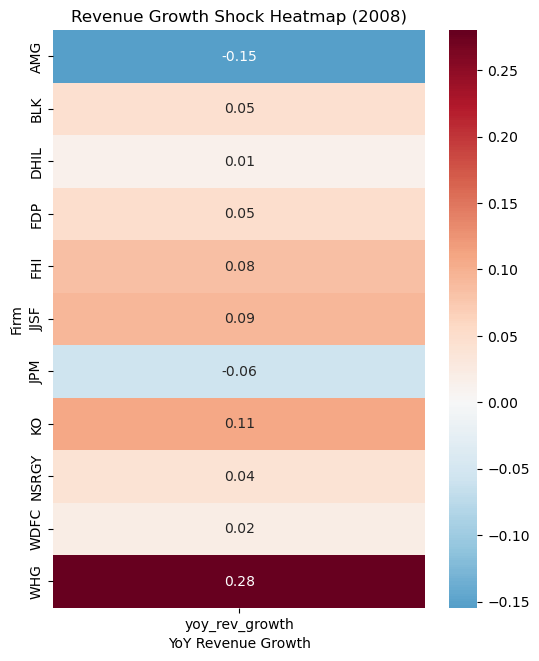

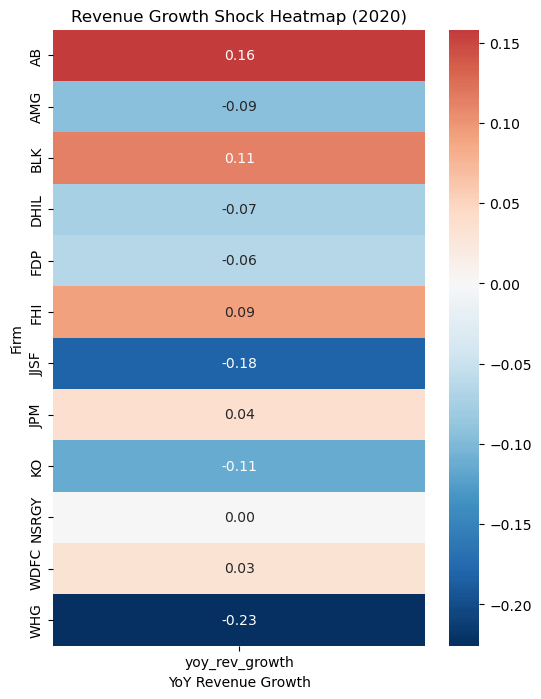

In [5]:
def crisis_heatmap(year, save_path=None):
    crisis = df[df["year"] == year].copy()
    crisis = crisis.pivot_table(index="ticker", values="yoy_rev_growth")

    plt.figure(figsize=(6, len(crisis)*0.5 + 2))
    sns.heatmap(crisis, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
    plt.title(f"Revenue Growth Shock Heatmap ({year})")
    plt.xlabel("YoY Revenue Growth")
    plt.ylabel("Firm")

    # Save BEFORE plt.show()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

crisis_heatmap(
    2008,
    save_path="/Users/hazel/Desktop/DATA 400/Final Project/heatmap_2008.png"
)

crisis_heatmap(
    2020,
    save_path="/Users/hazel/Desktop/DATA 400/Final Project/heatmap_2020.png"
)

# Bar Chart Operational Effect(Firm specific resilience)

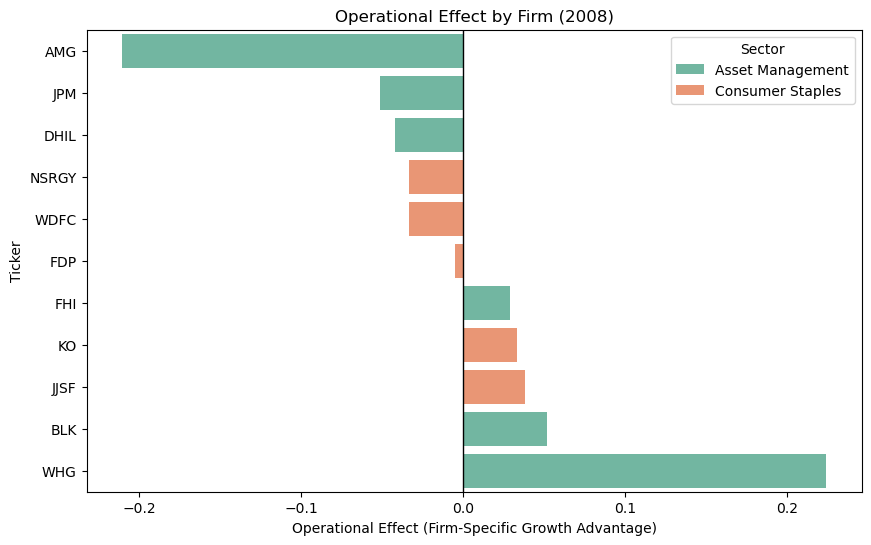

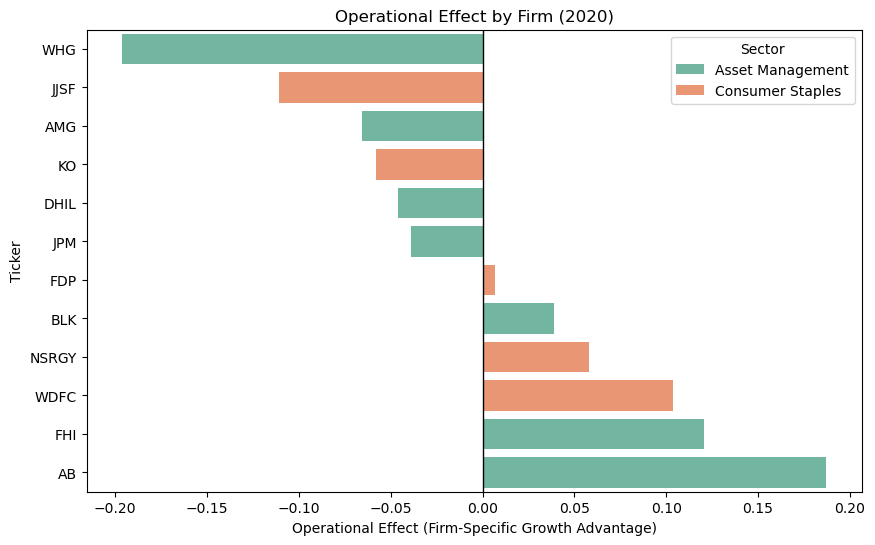

In [19]:
def operational_bar(year, save_path=None):
    crisis = df[df["year"] == year].copy()
    crisis = crisis.sort_values("operational_effect")

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=crisis,
        x="operational_effect",
        y="ticker",
        hue="sector",
        palette="Set2"
    )

    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"Operational Effect by Firm ({year})")
    plt.xlabel("Operational Effect (Firm-Specific Growth Advantage)")
    plt.ylabel("Ticker")
    plt.legend(title="Sector")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

operational_bar(
    2008,
    save_path="/Users/hazel/Desktop/DATA 400/Final Project/operational_effect_2008.png"
)

operational_bar(
    2020,
    save_path="/Users/hazel/Desktop/DATA 400/Final Project/operational_effect_2020.png"
)

# Crisis Impact 2008 & 2020

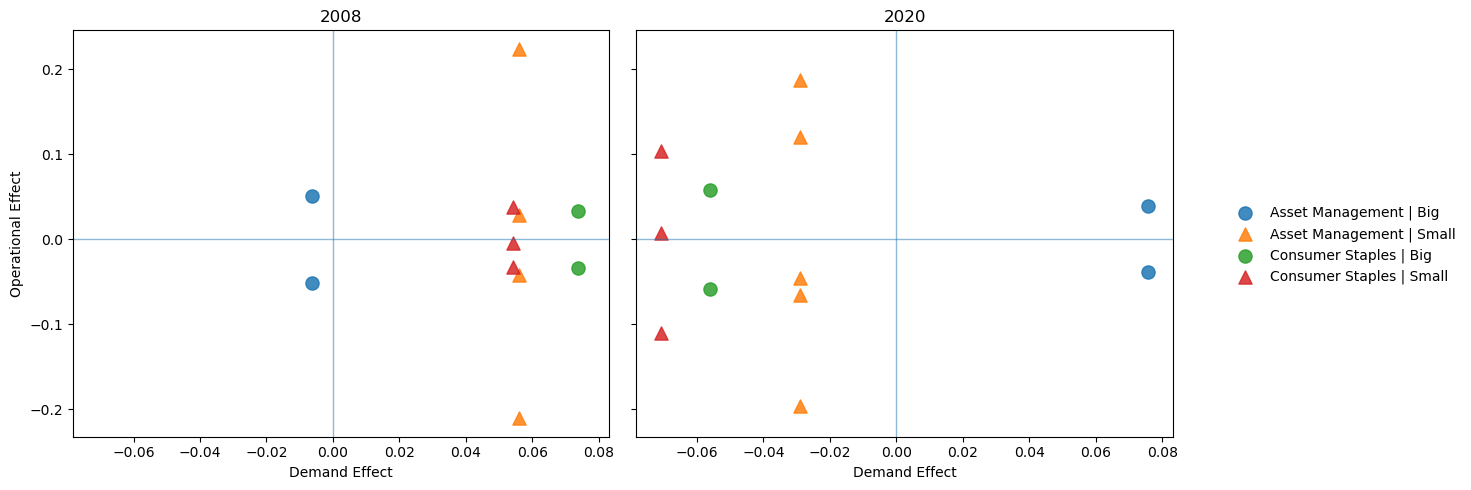

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

f08 = "/Users/hazel/Desktop/DATA 400/Final Project/Crisis_Impact_2008.csv"
f20 = "/Users/hazel/Desktop/DATA 400/Final Project/Crisis_Impact_2020.csv"

df = pd.concat([pd.read_csv(f08), pd.read_csv(f20)], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
marker = {"Big": "o", "Small": "^"}

for ax, yr in zip(axes, [2008, 2020]):
    sub = df[df["year"] == yr]
    for (sec, sz), g in sub.groupby(["sector", "size"]):
        ax.scatter(g["demand_effect"], g["operational_effect"], s=90,
                   marker=marker.get(sz, "o"), alpha=0.85, label=f"{sec} | {sz}")
    ax.axhline(0, linewidth=1, alpha=0.5)
    ax.axvline(0, linewidth=1, alpha=0.5)
    ax.set_title(str(yr))
    ax.set_xlabel("Demand Effect")

axes[0].set_ylabel("Operational Effect")
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("/Users/hazel/Desktop/DATA 400/Final Project/fundamentals_fingerprint.png", dpi=300, bbox_inches="tight")
plt.show()